In [2]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import numpy as np

# Purpose

## Compare sum and bulk EGAD outputs to look for GO terms of interest

In [3]:
sum_EGAD = pd.read_csv('../../data/EAGD/EGAD_sum_pc_OPfilteredGeneBalanced.csv')
bulk_EGAD = pd.read_csv('../../data/EAGD/EGAD_bulk15_pc_OPfilteredGeneBalanced.csv')
expr_bulk = pd.read_csv('../../data/bulk/bulk_pc.csv')
expr_sum = pd.read_csv('../../data/pseudobulk/sum_pseudobulk_pc.csv')

# Plot Sum and Bulk EGAD distribution

In [4]:
# change column names
sum_EGAD.columns = ('sum_auc','sum_avg_node_degree','sum_degree_null_auc')
bulk_EGAD.columns = ('bulk_auc','bulk_avg_node_degree','bulk_degree_null_auc')

In [5]:
#concat dfs
merged =  sum_EGAD.join(bulk_EGAD, how='inner')

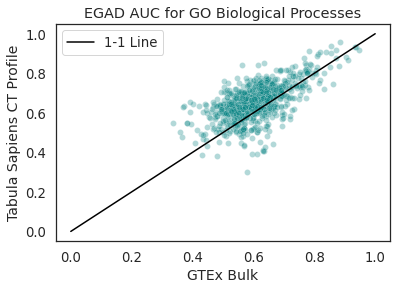

In [10]:
# Create the scatter plot with a new color
sns.scatterplot(data=merged, x='bulk_auc', y='sum_auc', alpha=0.3, color='teal')

# Add the diagonal line with a new color
sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='-', dashes=(5, 5), label='1-1 Line')

# Add lines for mean values with new colors
# mean_bulk = merged['bulk_auc'].mean()
# mean_sum = merged['sum_auc'].mean()
# plt.axhline(mean_sum, color='purple', linestyle='-', label='Mean Sum AUC')
# plt.axvline(mean_bulk, color='orange', linestyle='-', label='Mean Bulk AUC')

# Add title and axis labels
sns.set(font_scale=1.2)
plt.title('EGAD AUC for GO Biological Processes')
plt.xlabel('GTEx Bulk', fontsize=14)
plt.ylabel('Tabula Sapiens CT Profile', fontsize=14)

# Set plot style to remove grey background
sns.set_style("white")

# Add legend
plt.legend()

# Save the plot with higher DPI
plt.savefig('auc_comparison_plot.png', dpi=300)


In [11]:
np.corrcoef(merged.loc[:,'bulk_auc'], merged.loc[:,'sum_auc'])

array([[1.        , 0.63480556],
       [0.63480556, 1.        ]])

# Plot Sum and Bulk EGAD distribution

### But this time, iwant to color with a gradient by how many genes are in each GO term

In [222]:
GO = pd.read_csv('../../data/GO/pro_GO.csv')

In [223]:
def getNumGenesInGO(GO, expr):
    #get measured genes
    genes = expr.columns
    
    # Filter GO-Gene connections for only measured genes
    GO_filtered = GO[np.isin(GO.loc[:,"DB_Object_Symbol"], genes)]    

    # Count the number of genes in each GO term
    counts = GO_filtered.groupby('GO ID')['DB_Object_Symbol'].count()
    
    #return only the GO terms with 20>= genes
    
    return counts[counts>=20]

In [224]:
# Count the number of genes in each GO. Rename the series to "totalcount"
Genes_in_GO = GO.groupby('GO ID')['DB_Object_Symbol'].count().rename('totalCount')

# Join the Genes_in_Go df to our "merged" dataframe which has sum and bulk egad results
merged = merged.join(Genes_in_GO)

In [225]:
# Count the number of genes in our GO terms. This will be the total list so we have to join to our merged df later which contains only the genes we measured in both experiments
countsAbove20Bulk = getNumGenesInGO(GO, expr_bulk)
countsAbove20Sum = getNumGenesInGO(GO, expr_sum)
#Takes ~1m

In [226]:
#Rename series names
countsAbove20Bulk=countsAbove20Bulk.rename('count_bulk')
countsAbove20Sum=countsAbove20Sum.rename('count_sum')

# Join the counts to our merged dataframe
merged=merged.join(countsAbove20Bulk)
merged=merged.join(countsAbove20Sum)

In [255]:
# add log counts
merged['log10bulk'] =  np.log10(merged.loc[:,'count_bulk'])

In [228]:
# Get ratio indicating number of sum counts / number of bulk counts
merged['log2RatioSumOverBulk']=np.log2(np.divide(merged.loc[:,'count_sum'], merged.loc[:,'count_bulk']))

In [229]:
# Normalize this ratio to the total coutns in that GO Term
merged['log2RatioSumOverBulkDevTotal']=np.divide(merged.loc[:,'log2RatioSumOverBulk'], merged.loc[:,'totalCount'])

In [26]:
merged['nodedegdiff']=np.divide(merged.loc[:,'sum_avg_node_degree'], merged.loc[:,'bulk_avg_node_degree'])

In [29]:
merged.head()
# should have columns indicating the total number of GO terms in 

,sum_auc,sum_avg_node_degree,sum_degree_null_auc,bulk_auc,bulk_avg_node_degree,bulk_degree_null_auc,nodedegdiff
GO:0002250,0.831147,2719.316399,0.231538,0.810176,579.135868,0.304383,4.695472
GO:0045087,0.701519,3674.875307,0.419198,0.691846,835.293614,0.410886,4.399501
GO:0007186,0.747692,2523.991688,0.197523,0.665670,506.389712,0.260584,4.984287
GO:0050911,0.878121,1584.244912,0.089111,0.872950,303.825376,0.179319,5.214327
GO:0071230,0.635209,4260.001081,0.563532,0.584183,1206.851790,0.556204,3.529846


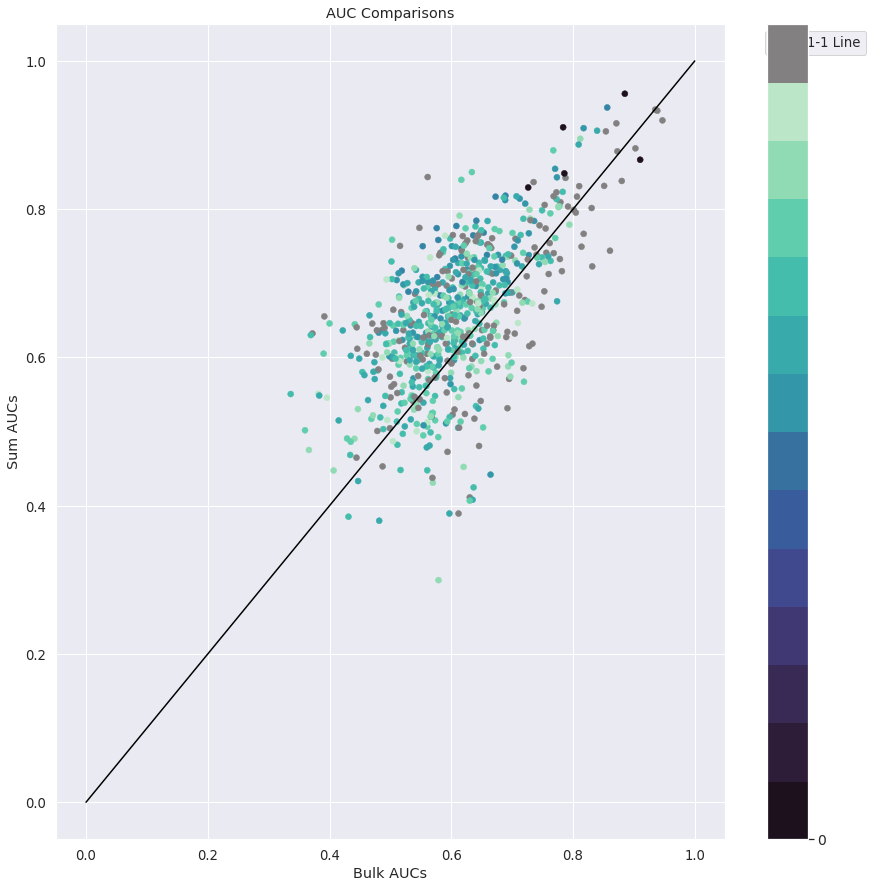

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Define the number of levels for the colormap
n_levels = 15

# Define the colormap
cmap_colors = sns.color_palette("mako", n_levels-1)
cmap_colors.append((0.51, 0.5, 0.5))  # add black color for values above 50
cmap = ListedColormap(cmap_colors)

# Define the color values for the scatterplot
vmin = 0
vmax = 5
c = np.clip(merged['nodedegdiff'], vmin, vmax)

# Map the color values to the colormap
color_map = plt.cm.ScalarMappable(cmap=cmap)
color_map.set_array([])

# Create the scatter plot with the custom colormap
plt.figure(figsize=(15, 15))
scatter_plot = sns.scatterplot(data=merged, x='bulk_auc', y='sum_auc', alpha=1, hue=c, palette=cmap, legend=False, vmax=vmax, vmin=vmin)
scatter_plot.collections[0].set_edgecolor("face")

# Add colorbar manually
bounds = np.linspace(vmin, vmax, n_levels)
ticks = np.arange(vmin, vmax+1, 10)
cbar = plt.colorbar(color_map, ticks=ticks, boundaries=bounds)
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=14)

# Add the diagonal line with a new color
line_plot = sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='-', dashes=(5, 5), label='1-1 Line')

# Add lines for mean values with new colors
# mean_bulk = merged['bulk_auc'].mean()
# mean_sum = merged['sum_auc'].mean()
# plt.axhline(mean_sum, color='purple', linestyle='-', label='Mean Sum AUC')
# plt.axvline(mean_bulk, color='orange', linestyle='-', label='Mean Bulk AUC')

# Add title and axis labels
sns.set(font_scale=1.2)
plt.title('AUC Comparisons')
plt.xlabel('Bulk AUCs')
plt.ylabel('Sum AUCs')

# Move the legend to the right side of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [256]:
merged.sort_values(by = 'log10bulk', ascending=False).head()

,sum_auc,sum_avg_node_degree,sum_degree_null_auc,bulk_auc,bulk_avg_node_degree,bulk_degree_null_auc,totalCount,count_bulk,count_sum,log10bulk,log2RatioSumOverBulk,log2RatioSumOverBulkDevTotal
GO:0045944,0.586211,4051.159586,0.499109,0.531965,1295.579346,0.537844,1878,1011,1862,3.004751,0.881070,0.000469
GO:0006357,0.598750,4075.245523,0.501157,0.549400,1333.322292,0.536917,1450,742,1399,2.870404,0.914905,0.000631
GO:0000122,0.602348,4223.648310,0.530273,0.525763,1387.510784,0.557578,1276,631,1248,2.800029,0.983906,0.000771
GO:0007165,0.613368,3759.429932,0.413924,0.544636,1022.097331,0.444519,1162,611,1123,2.786041,0.878114,0.000756
GO:0045893,0.601646,4367.285682,0.575627,0.566095,1478.187417,0.592107,999,517,979,2.713491,0.921145,0.000922


In [250]:
merged.columns

Index(['sum_auc', 'sum_avg_node_degree', 'sum_degree_null_auc', 'bulk_auc',
       'bulk_avg_node_degree', 'bulk_degree_null_auc', 'totalCount',
       'count_bulk', 'count_sum', 'log10bulk', 'log2RatioSumOverBulk',
       'log2RatioSumOverBulkDevTotal'],
      dtype='object')

Get Means


In [232]:
mean_bulk = merged['bulk_auc'].median()
mean_sum = merged['sum_auc'].median()

In [233]:
print(mean_bulk)
print(mean_sum)

0.555100418725883
0.65535751152708


# Identify GO's of interest



In [257]:
def filter_dataframe_by_bounds(df, column_name, lower_bound, upper_bound):
    """
    Filter a pandas dataframe by a column within a given range.

    Args:
        df (pandas.DataFrame): The pandas dataframe to filter.
        column_name (str): The name of the column to filter on.
        lower_bound (float): The lower bound of the range.
        upper_bound (float): The upper bound of the range.

    Returns:
        pandas.DataFrame: The filtered dataframe.
    """
    return df[(df[column_name] > lower_bound) & (df[column_name] < upper_bound)]


In [350]:
interest_HB = filter_dataframe_by_bounds(filter_dataframe_by_bounds(merged, 'bulk_auc', lower_bound=0.5, upper_bound=0.7), 'sum_auc', lower_bound=0.8, upper_bound=1)

In [351]:
interest_HB.head()

,sum_auc,sum_avg_node_degree,sum_degree_null_auc,bulk_auc,bulk_avg_node_degree,bulk_degree_null_auc,totalCount,count_bulk,count_sum,log10bulk,log2RatioSumOverBulk,log2RatioSumOverBulkDevTotal
GO:0007156,0.823433,3417.795255,0.325520,0.647977,1524.881949,0.584182,180,110,179,2.041393,0.702456,0.003903
GO:0006334,0.816898,4977.623657,0.712884,0.587617,2112.726838,0.771042,112,36,61,1.556303,0.760812,0.006793
GO:0061844,0.822791,2474.237097,0.216773,0.643447,50.208724,0.252625,95,60,88,1.778151,0.552541,0.005816
GO:0006364,0.854485,5232.418912,0.778220,0.663762,2086.843242,0.755111,116,60,115,1.778151,0.938599,0.008091
GO:0000398,0.818266,5317.510629,0.873702,0.582614,2436.030122,0.873200,413,190,409,2.278754,1.106101,0.002678


## GO:0072488	

The highest bulk point.


# Graphing Expression of Genes in GO:0072488	

Get Genes in GO

In [237]:
GO1 = GO[GO.loc[:,'GO ID'] == 'GO:0072488']

In [238]:
len(GO1.iloc[:,0].unique()) # There are 38 genes that we have data for in this GO term.. I have a bug

9

Retreive Expression of those genes

In [4]:
# load expression data 
expr_bulk = pd.read_csv('../../data/bulk/bulk_K15_pc.csv', compression='gzip')
expr_sum = pd.read_csv('../../data/pseudobulk/sum_pseudobulk_pc.csv')

In [310]:
expr_bulk.shape

(435, 31070)

In [241]:
# Get Expression data for the GO term in bulk and sum data
expr_GO1_bulk = expr_bulk.loc[:,expr_bulk.columns.isin(GO1.loc[:,'DB_Object_Symbol'])] # has 3 genes
expr_GO1_sum = expr_sum.loc[:,expr_sum.columns.isin(GO1.loc[:,'DB_Object_Symbol'])] # has 9 genes

bulk_GO_annot = pd.DataFrame({'gene':expr_GO1_bulk.columns,
                               'meta':'GO'})
sum_GO_annot = pd.DataFrame({'gene':expr_GO1_sum.columns,
                               'meta':'GO'})

# # Add a metadata column saying these are GO affiliated genes
# expr_GO1_bulk = expr_GO1_bulk.assign(meta="GO")
# expr_GO1_sum = expr_GO1_sum.assign(meta="GO")

# # Melt dataframes by meta column
# melt_GO1_bulk = pd.melt(expr_GO1_bulk, id_vars=['meta'], var_name='variable', value_name='value')
# melt_GO1_sum = pd.melt(expr_GO1_sum, id_vars=['meta'], var_name='variable', value_name='value')


In [242]:
# Sample 50 random expression profiles
expr_bulk_rand = expr_bulk.sample(n=10, axis=1)
expr_sum_rand = expr_sum.sample(n=10, axis = 1)

#build annot table 
bulk_rand_annot = pd.DataFrame({'gene':expr_bulk_rand.columns,
                               'meta':'rand'})
sum_rand_annot = pd.DataFrame({'gene':expr_sum_rand.columns,
                               'meta':'rand'})

# # Add a metadata column saying these are random affiliated genes
# expr_GO1_bulk = expr_GO1_bulk.assign(meta="rand")
# expr_GO1_sum = expr_GO1_sum.assign(meta="rand")


# # Melt dataframes by meta column
# melt_GO1_bulk = pd.melt(expr_GO1_bulk, id_vars=['meta'], var_name='variable', value_name='value')
# melt_GO1_sum = pd.melt(expr_GO1_sum, id_vars=['meta'], var_name='variable', value_name='value')



In [243]:
# concat dataframes
plot_GO1_bulk = pd.concat([expr_GO1_bulk, expr_bulk_rand], axis = 1)
plot_GO1_sum = pd.concat([expr_GO1_sum,expr_sum_rand], axis = 1)

# Concat annotation dfs
annot_df_bulk = pd.concat([bulk_GO_annot,bulk_rand_annot], axis = 0)
annot_df_bulk.index = annot_df_bulk.iloc[:,0]
annot_df_bulk = annot_df_bulk.iloc[:,1]

annot_df_sum = pd.concat([sum_GO_annot,sum_rand_annot], axis = 0)
annot_df_sum.index = annot_df_sum.iloc[:,0]
annot_df_sum = annot_df_sum.iloc[:,1]



In [244]:
# Prepare Categorical variable
my_palette = {'rand': 'blue',
              'GO': 'red'}

# row colors is a series where index is gene, and value is the color that that gene needs to be 
row_colors_bulk= annot_df_bulk.map(my_palette)
row_colors_sum= annot_df_sum.map(my_palette)

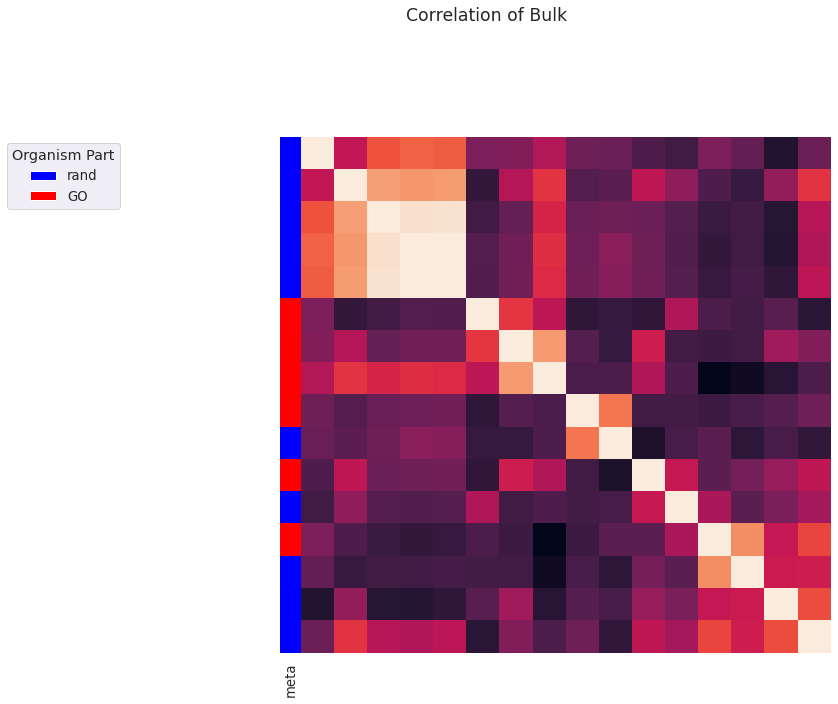

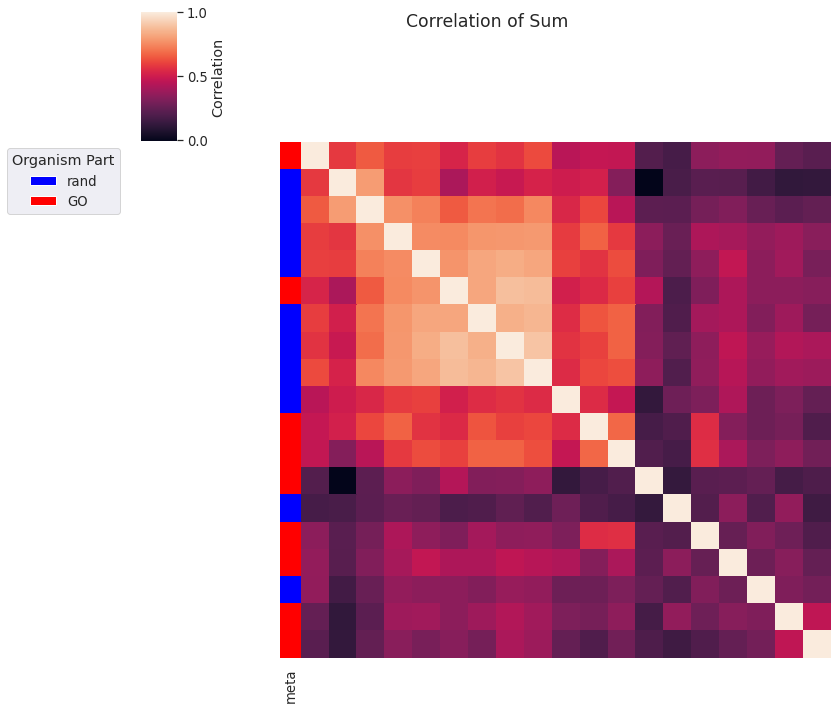

In [303]:
from matplotlib.patches import Patch

# Create the first cluster map
fig1 = sns.clustermap(plot_GO1_bulk.corr(), row_colors=row_colors_bulk, cbar_pos=None, xticklabels=False,
                      yticklabels=False, dendrogram_ratio=0.2)
# Set the title of the first plot
fig1.fig.suptitle("Correlation of Bulk")

# Remove the dendrograms from the first plot
fig1.ax_row_dendrogram.set_visible(False)
fig1.ax_col_dendrogram.set_visible(False)

# Add a legend
handles = [Patch(facecolor=my_palette[key]) for key in my_palette]
plt.legend(handles, my_palette, title='Organism Part',
           bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Create the second cluster map
fig2 = sns.clustermap(plot_GO1_sum.corr(), row_colors=row_colors_sum, cbar_kws={'label': 'Correlation'}, 
                      xticklabels=False, yticklabels=False, dendrogram_ratio=0.2)
# Set the title of the second plot
fig2.fig.suptitle("Correlation of Sum")

# Remove the dendrograms from the second plot
fig2.ax_row_dendrogram.set_visible(False)
fig2.ax_col_dendrogram.set_visible(False)

# Add a legend
handles = [Patch(facecolor=my_palette[key]) for key in my_palette]
plt.legend(handles, my_palette, title='Organism Part',
           bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Display the figure
plt.show()

In [269]:
    sharedgenes = pd.read_csv('../../data/pc_genes/scAndBulkOverlapGenes.txt', header=None)
sharedgenes

,0
0,SAMD11
1,NOC2L
2,KLHL17
3,PLEKHN1
4,PERM1
...,...
9854,NPAS4
9855,MRPL11
9856,PELI3
9857,DPP3


In [273]:
np.sum(np.isin(expr_bulk.columns, sharedgenes.iloc[:,0]))

9859

In [278]:
np.sum(np.isin(expr_bulk.columns, expr_sum.columns))

9860

In [280]:
sharedgenes = np.isin(expr_bulk.columns, expr_sum.columns)

In [285]:
exprtest = expr_bulk.columns[np.isin(expr_bulk.columns, expr_sum.columns)][1:]

In [288]:
test = expr_sum.loc[:, sharedgenes]
test.head()

IndexError: Boolean index has wrong length: 9865 instead of 18259

In [289]:
    expr_sum = expr_sum .iloc[:, np.isin(expr_sum.columns, expr_bulk.columns)]


GO:0000387



In [347]:
def GOvsRand(GOstr, GO, expr_bulk, expr_sum, k, title: str ):
        GO1 = GO[GO.loc[:,'GO ID'] == GOstr]
        # Filter expression data for only genes that are shared and PC
        expr_bulk = expr_bulk.iloc[:, np.isin(expr_bulk.columns, expr_sum.columns)]
        expr_sum = expr_sum .iloc[:, np.isin(expr_sum.columns, expr_bulk.columns)]

        # Get Expression data for the GO term in bulk and sum data
        expr_GO1_bulk = expr_bulk.loc[:,expr_bulk.columns.isin(GO1.loc[:,'DB_Object_Symbol'])] # has 3 genes
        expr_GO1_sum = expr_sum.loc[:,expr_sum.columns.isin(GO1.loc[:,'DB_Object_Symbol'])] # has 9 genes

        bulk_GO_annot = pd.DataFrame({'gene':expr_GO1_bulk.columns,
                                'meta':'GO'})
        sum_GO_annot = pd.DataFrame({'gene':expr_GO1_sum.columns,
                                'meta':'GO'})

        k = k
        # Sample 50 random expression profiles
        expr_bulk_rand = expr_bulk.sample(n=k, axis=1)
        expr_sum_rand = expr_sum.sample(n=k, axis = 1)



        #build annot table 
        bulk_rand_annot = pd.DataFrame({'gene':expr_bulk_rand.columns,
                                'meta':'rand'})
        sum_rand_annot = pd.DataFrame({'gene':expr_sum_rand.columns,
                                'meta':'rand'})


        # concat dataframes
        plot_GO1_bulk = pd.concat([expr_GO1_bulk, expr_bulk_rand], axis = 1)
        plot_GO1_sum = pd.concat([expr_GO1_sum,expr_sum_rand], axis = 1)

        # Concat annotation dfs
        annot_df_bulk = pd.concat([bulk_GO_annot,bulk_rand_annot], axis = 0)
        annot_df_bulk.index = annot_df_bulk.iloc[:,0]
        annot_df_bulk = annot_df_bulk.iloc[:,1]

        annot_df_sum = pd.concat([sum_GO_annot,sum_rand_annot], axis = 0)
        annot_df_sum.index = annot_df_sum.iloc[:,0]
        annot_df_sum = annot_df_sum.iloc[:,1]


        my_palette = {'rand': 'blue',
                'GO': 'red'}

        # row colors is a series where index is gene, and value is the color that that gene needs to be 
        row_colors_bulk= annot_df_bulk.map(my_palette)
        row_colors_sum= annot_df_sum.map(my_palette)


        # Create the first cluster map
        fig1 = sns.clustermap(plot_GO1_bulk.corr(), row_colors=row_colors_bulk, cbar_pos=None, xticklabels=False,
                                yticklabels=False, dendrogram_ratio=0.2)
        # Set the title of the first plot
        fig1.fig.suptitle(f'{title} Corr Bulk')

        # Remove the dendrograms from the first plot
        fig1.ax_row_dendrogram.set_visible(False)
        fig1.ax_col_dendrogram.set_visible(False)

        # Add a legend
        handles = [Patch(facecolor=my_palette[key]) for key in my_palette]
        plt.legend(handles, my_palette, title='GO Affiliation',
                bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

        # Create the second cluster map
        fig2 = sns.clustermap(plot_GO1_sum.corr(), row_colors=row_colors_sum, cbar_kws={'label': 'Correlation'}, 
                                xticklabels=False, yticklabels=False, dendrogram_ratio=0.2)
        # Set the title of the second plot
        fig2.fig.suptitle(f'{title} Corr Pseudobulk')

        # Remove the dendrograms from the second plot
        fig2.ax_row_dendrogram.set_visible(False)
        fig2.ax_col_dendrogram.set_visible(False)

        # Add a legend
        handles = [Patch(facecolor=my_palette[key]) for key in my_palette]
        plt.legend(handles, my_palette, title='GO Affiliation',
                bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')

        # Display the figure
        plt.show()

/home/aadrian/anaconda3/envs/PseudoPipelineEnv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


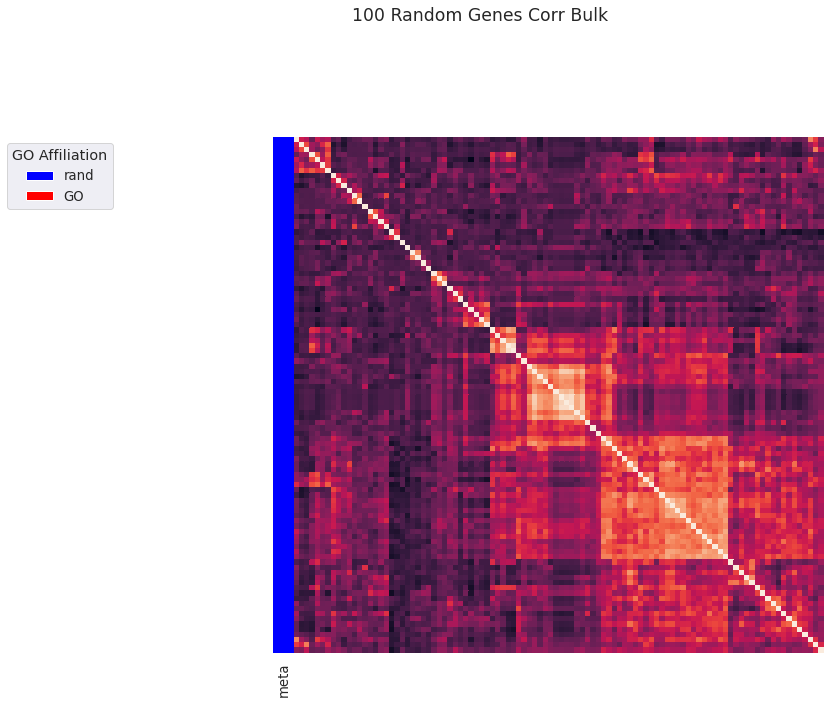

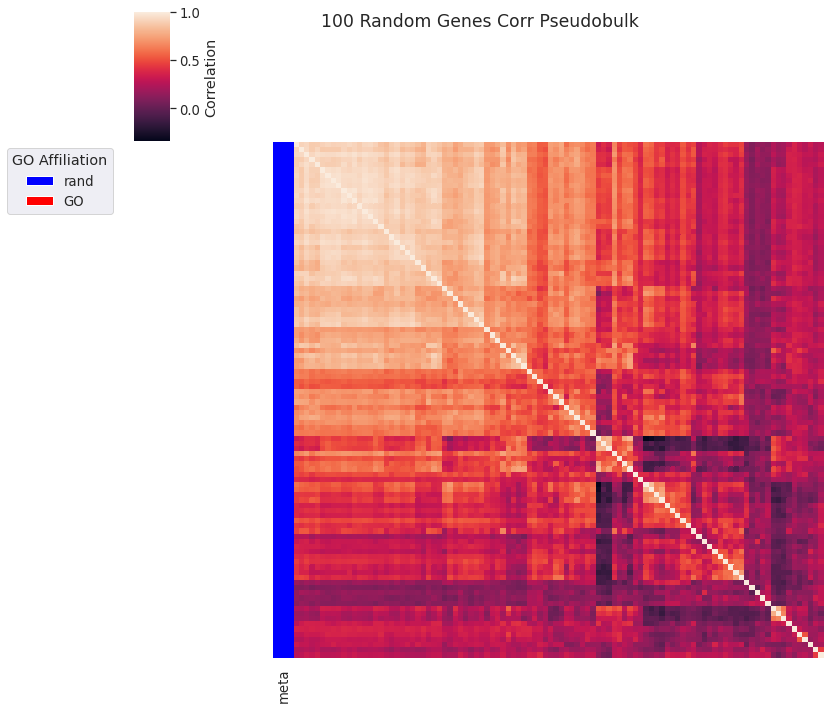

In [357]:
GOvsRand(GOstr="GO0006334", GO=GO, expr_bulk=expr_bulk, expr_sum=expr_sum, k = 100, title = "100 Random Genes")

In [ ]:
def AvgCor(expr_bulk, expr_sum):
        # Filter expression data for only genes that are shared and PC
        expr_bulk = expr_bulk.iloc[:, np.isin(expr_bulk.columns, expr_sum.columns)]
        expr_sum = expr_sum .iloc[:, np.isin(expr_sum.columns, expr_bulk.columns)]

        expr_bulk.corr()
        

In [5]:
# Filter expression data for only genes that are shared and PC
expr_bulk = expr_bulk.iloc[:, np.isin(expr_bulk.columns, expr_sum.columns)]
expr_sum = expr_sum.iloc[:, np.isin(expr_sum.columns, expr_bulk.columns)]

In [7]:
bulk_cor = expr_bulk.corr()

In [10]:
import pandas as pd
import numpy as np

def remove_upper_triangle(df):
    """Removes the upper triangle of a square DataFrame in-place."""
    n = df.shape[0]
    upper_indices = np.triu_indices(n, k=1)
    df.iloc[upper_indices] = 0
    return df


In [11]:
lower_bulk_cor = remove_upper_triangle(bulk_cor)

# Node Degree Bias

In [ ]:
sns.kdeplot(merged, x =

In [16]:
merged.loc[:,['sum_avg_node_degree', 'bulk_avg_node_degree']]

,sum_avg_node_degree,bulk_avg_node_degree
GO:0002250,2719.316399,579.135868
GO:0045087,3674.875307,835.293614
GO:0007186,2523.991688,506.389712
GO:0050911,1584.244912,303.825376
GO:0071230,4260.001081,1206.851790
...,...,...
GO:1905515,4725.461891,1536.490086
GO:0015908,3441.058605,405.260031
GO:0007275,3226.352156,821.542389
GO:0031146,5000.322972,1583.833289


In [18]:
merged_melt = pd.melt(merged.loc[:,['sum_avg_node_degree', 'bulk_avg_node_degree']])

Text(0.5, 0, 'Node Degree')

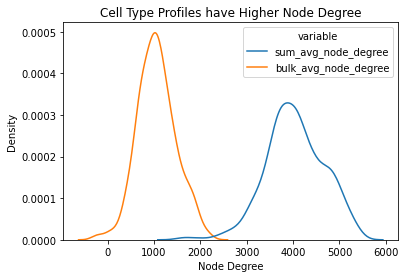

In [25]:
sns.kdeplot(merged_melt, x = 'value', hue = 'variable')
plt.title('Cell Type Profiles have Higher Node Degree')
plt.xlabel('Node Degree')